In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import and inspect the data

In [ ]:
# download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

# more info: https://www.nist.gov/itl/products-and-services/emnist-dataset

0.6%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

1.5%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

2.4%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

3.7%IOPub message rate exceeded.
T

In [ ]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(images.shape)

In [ ]:
# brief aside: class 'N/A' doesn't exist in the data.
print( torch.sum(cdata.targets==0) )

# However, it causes problems in one-hot encoding...
torch.unique(cdata.targets)

In [6]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [ ]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels = copy.deepcopy(cdata.targets)-1
print(labels.shape)

### 
print( torch.sum(labels==0) )
torch.unique(labels)

In [ ]:
# next issue: do we need to normalize the images?
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('Raw values')
plt.show()

# yarp.
images /= torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('After normalization')
plt.show()

In [ ]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

    # pick a random pic
    whichpic = np.random.randint(images.shape[0])

    # extract the image and its target letter
    I = np.squeeze( images[whichpic,:,:] )
    letter = letterCategories[labels[whichpic]]

    # visualize
    ax.imshow(I.T,cmap='gray')
    ax.set_title('The letter "%s"'%letter)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Create train/test groups using DataLoader

In [ ]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

# Create the DL model

In [ ]:
# create a class for the model
def makeTheNet(printtoggle=False):

    class emnistnet(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()

            # print toggle
            self.print = printtoggle

            ### -------------- feature map layers -------------- ###
            # first convolution layer
            self.conv1  = nn.Conv2d(1,6,3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels in this layer
            # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

            # second convolution layer
            self.conv2  = nn.Conv2d(6,6,3,padding=1)
            self.bnorm2 = nn.BatchNorm2d(6) # input the number of channels in this layer
            # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)


            ### -------------- linear decision layers -------------- ###
            self.fc1 = nn.Linear(7*7*6, 50)
            self.fc2 = nn.Linear(50,26)

        def forward(self,x):
      
            if self.print: print(f'Input: {list(x.shape)}')

            # first block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv1(x),2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print: print(f'First CPR block: {list(x.shape)}')

            # second block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv2(x),2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print: print(f'Second CPR block: {list(x.shape)}')

            # reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            if self.print: print(f'Final output: {list(x.shape)}')

            return x

    # create the model instance
    net = emnistnet(printtoggle)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.001)

    return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = iter(train_loader).next()
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

# Create a function that trains the model

In [ ]:
# a function that trains the model

def function2trainTheModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net,lossfun,optimizer = makeTheNet()

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)
    trainErr  = torch.zeros(numepochs)
    testErr   = torch.zeros(numepochs)


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchLoss = []
        batchErr  = []
        for X,y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and error from this batch
            batchLoss.append(loss.item())
            batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
        # end of batch loop...

        # and get average losses and error rates across the batches
        trainLoss[epochi] = np.mean(batchLoss)
        trainErr[epochi]  = 100*np.mean(batchErr)



        ### test performance
        net.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
            loss = lossfun(yHat,y)
      
        # get loss and error rate from the test batch
        testLoss[epochi] = loss.item()
        testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

    # end epochs

    # function output
    return trainLoss,testLoss,trainErr,testErr,net

# Run the model and show the results!

In [14]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel()

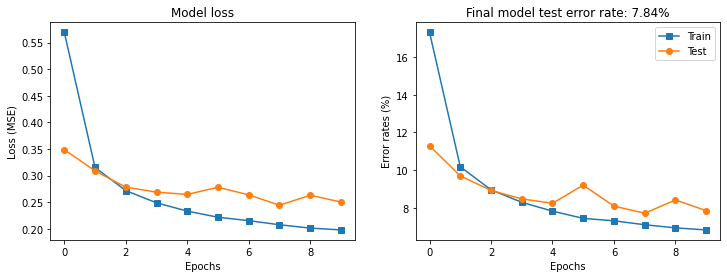

In [15]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

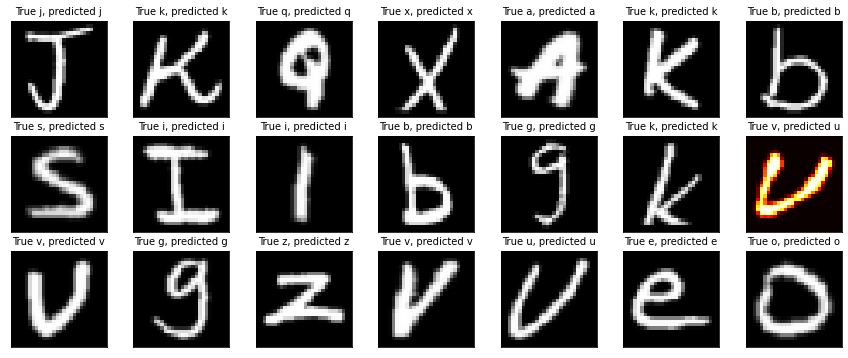

In [16]:
### visualize some images

# extract X,y from test dataloader
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = net(X)

# pick some examples at random to show
randex = np.random.choice(len(y),size=21,replace=False)

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):

    # extract the image and its target letter
    I = np.squeeze( X[randex[i],0,:,:] ).cpu() # .cpu() to transfer back from GPU!
    trueLetter = letterCategories[ y[randex[i]] ]
    predLetter = letterCategories[ torch.argmax(yHat[randex[i],:]) ]

    # color-code the accuracy (using ternary operator)
    col = 'gray' if trueLetter==predLetter else 'hot'

    # visualize
    ax.imshow(I.T,cmap=col)
    ax.set_title('True %s, predicted %s' %(trueLetter,predLetter),fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Accuracy by letter

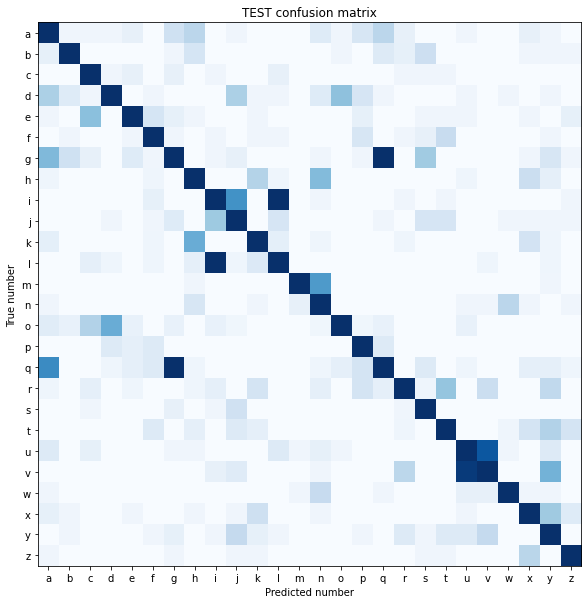

In [17]:
import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(yHat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(26),labels=letterCategories)
plt.yticks(range(26),labels=letterCategories)
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')

plt.show()

# Additional explorations

In [ ]:
# 1) I added batch normalization to the convolution layers, but not to the linear (fc*) layers. But linear layers also 
#    benefit from batchnorm just like convolution layers do. Add it!
# 
# 2) In the next few videos, we will see whether we can improve the model's performance by experimenting with the number
#    of layers, kernel size, and linear-layer units. Is there anything you could think of, other than these three features,
#    that might help boost model performance?
# 